### CIFAR-10 데이터셋 준비하기

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import urllib3
urllib3 .disable_warnings()

(ds_train, ds_test), ds_info = tfds.load('cifar10',
                                        split = ['train', 'test'],
                                        shuffle_files = True,
                                        with_info = True)

In [5]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [7]:
# 정규화
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features['label'].num_classes

10

In [10]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

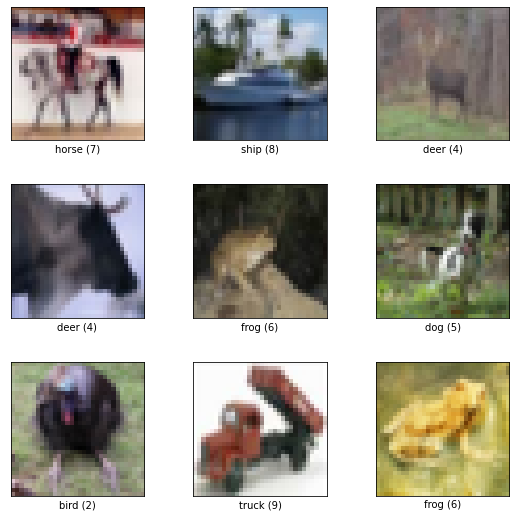

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

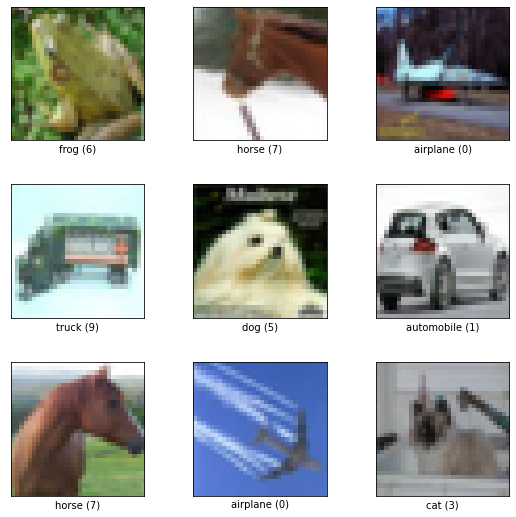

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

### 블록 구성하기

#### VGG

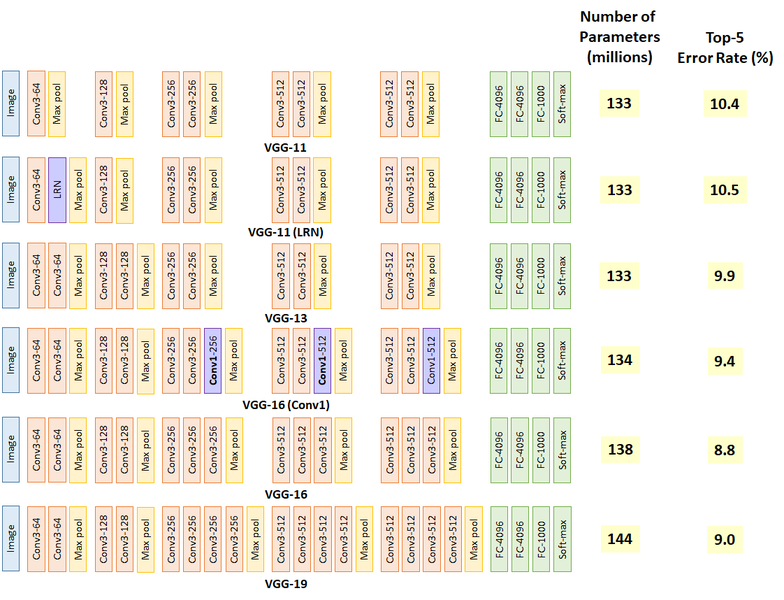

In [17]:
def build_vgg_block(input_layer, num_cnn=3, channel=64, block_num=1,):
    x = input_layer
    
    # CNN layer
    for cnn in range(num_cnn):
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), activation='relu',
                                kernel_initializer='he_normal', padding='same', name=f'block{block_num}_conv{cnn}')(x)
        
    # Max Pooling layer
    x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, name=f'block{block_num}_pooling')(x)
        
    return x

In [18]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))
vgg_block_output = build_vgg_block(vgg_input_layer)

In [19]:
# 블록 1개짜리 model 생성

model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


In [28]:
# VGG-16

def build_vgg(input_shape=(32,32,3),
          num_cnn_list=[2, 2, 3, 3, 3],
          channel_list = [64, 128, 256, 512, 512],
          num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    for i,(num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(output, num_cnn=num_cnn, channel=channel, block_num=i)    
        # 위에서 구현한대로 num_cnn_list 만큼 for문을 돌면서 convolution 연산 후 maxpool 1회
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

In [30]:
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [31]:
# VGG-19

vgg_19 = build_vgg(num_cnn_list=[2, 2, 4, 4, 4],
                  channel_list = [64, 128, 256, 512, 512])

vgg_19.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### VGG-16 vs VGG-19

In [32]:
BATCH_SIZE = 256
EPOCH = 20

In [33]:
(ds_train, ds_test), ds_info = tfds.load('cifar10',
                                         split=['train', 'test'],
                                        as_supervised=True,
                                        shuffle_files=True,
                                        with_info=True)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [34]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 153s 617ms/step - loss: 2.2573 - accuracy: 0.1564 - val_loss: 2.0615 - val_accuracy: 0.2435
Epoch 2/20
195/195 [==============================] - 92s 470ms/step - loss: 2.0349 - accuracy: 0.2594 - val_loss: 1.9279 - val_accuracy: 0.2978
Epoch 3/20
195/195 [==============================] - 101s 521ms/step - loss: 1.8918 - accuracy: 0.3217 - val_loss: 1.7941 - val_accuracy: 0.3742
Epoch 4/20
195/195 [==============================] - 99s 510ms/step - loss: 1.7863 - accuracy: 0.3575 - val_loss: 1.6872 - val_accuracy: 0.4085
Epoch 5/20
195/195 [==============================] - 102s 524ms/step - loss: 1.6924 - accuracy: 0.3917 - val_loss: 1.6110 - val_accuracy: 0.4267
Epoch 6/20
195/195 [==============================] - 103s 531ms/step - loss: 1.6220 - accuracy: 0.4122 - val_loss: 1.5635 - val_accuracy: 0.4370
Epoch 7/20
195/195 [==============================] - 103s 528ms/step - loss: 1.5682 - accuracy: 0.4340 - val_loss: 1.5640 - v

In [35]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 76s 341ms/step - loss: 2.2694 - accuracy: 0.1492 - val_loss: 2.0982 - val_accuracy: 0.2165
Epoch 2/20
195/195 [==============================] - 67s 344ms/step - loss: 2.0577 - accuracy: 0.2486 - val_loss: 1.9265 - val_accuracy: 0.3015
Epoch 3/20
195/195 [==============================] - 68s 350ms/step - loss: 1.9036 - accuracy: 0.3106 - val_loss: 1.8107 - val_accuracy: 0.3521
Epoch 4/20
195/195 [==============================] - 68s 351ms/step - loss: 1.7803 - accuracy: 0.3537 - val_loss: 1.7082 - val_accuracy: 0.3841
Epoch 5/20
195/195 [==============================] - 75s 383ms/step - loss: 1.6948 - accuracy: 0.3912 - val_loss: 1.6182 - val_accuracy: 0.4206
Epoch 6/20
195/195 [==============================] - 96s 493ms/step - loss: 1.6280 - accuracy: 0.4142 - val_loss: 1.5392 - val_accuracy: 0.4539
Epoch 7/20
195/195 [==============================] - 69s 352ms/step - loss: 1.5573 - accuracy: 0.4426 - val_loss: 1.5480 - val_ac

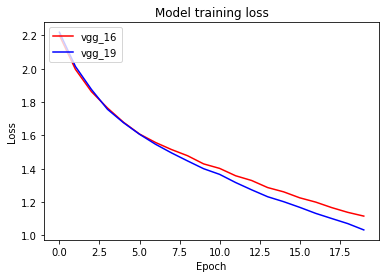

In [36]:
# 그래프 비교
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

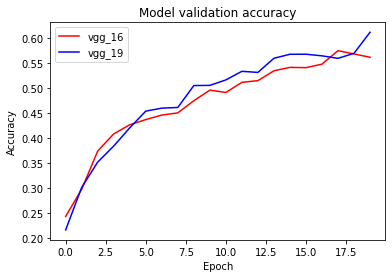

In [37]:
# 검증 정확도 (validation accuracy) 비교
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()